## Setup

In [1]:
# set working directory
setwd("/Genomics/pritykinlab/adina/bulkrna-differential-analysis/penn")

In [2]:
# load libraries
library(SummarizedExperiment)
library(DESeq2)
library(pheatmap)
library(ggplot2)
library(EnhancedVolcano)

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles, rowRanges, rowRanks,
    rowSdDiffs, rowSds, rowSums2, ro

In [3]:
# create function to normalize counts in deseq object

# assume rowRanges is a non-empty GRangesList and size factors were already computed (ex: using estimateSizeFactors())
normCounts <- function(se) {
  gene_length <- sum(width(rowRanges(se)))
  counts_norm <- apply(counts(se, normalized = TRUE), 2, 
                       function(x) {
                         1e3 * x / gene_length
                       })
  assays(se)$counts_norm <- counts_norm
  return(se)
}


In [4]:
# get functions from other files

# function to create a deseq dataset
source("/Genomics/pritykinlab/adina/bulkrna-differential-analysis/functions_and_snippets/create_deseq_dataset.R")

# function to get de genes
source("/Genomics/pritykinlab/adina/bulkrna-differential-analysis/functions_and_snippets/get_de_genes.R")


Attaching package: ‘glue’


The following object is masked from ‘package:SummarizedExperiment’:

    trim


The following object is masked from ‘package:GenomicRanges’:

    trim


The following object is masked from ‘package:IRanges’:

    trim




## Read data

In [5]:
# read in data

# define the root directory
root = "/Genomics/pritykinlab/share/eileen-rnaseq/processed"

# read in gene expression data
gene_counts <- readRDS(glue('{root}/upenn-rna-counts.raw.rds'))

# read in gencode
gencode <- readRDS(glue('{root}/hg38_gencode.rds'))

# read in metadata
metadata <- read.csv(glue('{root}/upenn_metadata_cleaned.csv'), check.names = FALSE)


## Preprocess data

In [6]:
# prepare collection of all protein-coding exons for genes in gencode
exons <- gencode[(gencode$gene_type == 'protein_coding') & (gencode$type == 'exon')]
genes <- levels(as.factor(exons$gene_name))
exons_genes <- disjoin(split(exons, factor(exons$gene_name, levels = genes)))


In [7]:
# save the gene counts counts data in a dataframe
gene_counts_df <- as.data.frame(gene_counts$counts)

# fix the column headers of the gene counts data
names(gene_counts_df) <- gsub(".bam", "", names(gene_counts_df))

# put gene counts into a matrix
gene_counts_mat <- as.matrix(gene_counts_df)

# sort the gene names
#gene_names <- sort(rownames(gene_counts_mat))
gene_names <- sort(names(exons_genes))

# order gene_counts_mat according to sorted rownames
gene_counts_mat <- gene_counts_mat[gene_names, ]

# sort exons_genes
exons_genes <- exons_genes[gene_names]


In [8]:
# replace spaces in header of metadata with underscore
names(metadata) <- gsub(" ", "_", names(metadata))

# set the rownames of the metadata to be the sample names
rownames(metadata) <- metadata$Sample_Name

# drop the extra index column from the metadata
metadata = subset(metadata, select = -c(1))

# change Condition column from character to factor
metadata$Condition <- as.factor(metadata$Condition)

# view the beginning of the metadata
head(metadata)


,Sample_Name,Azenta_ID,On_tube,Group_ID,Condition
,<chr>,<chr>,<chr>,<chr>,<fct>
ND224-d0,ND224-d0,SEF14845,,ND224,Activated
ND224-d9-NTD,ND224-d9-NTD,SEF14846,,ND224,Activated
ND224-d9-GFP,ND224-d9-GFP,SEF14847,,ND224,Activated
ND224-d12-18,ND224-d12-18,SEF14848,"""D12"" on tube",ND224,Activated
ND224-d12-21,ND224-d12-21,SEF14849,"""D12"" on tube",ND224,Activated
ND224-d9-GOT2,ND224-d9-GOT2,SEF14850,,ND224,Activated


In [9]:
# sort the gene_counts_mat to be in the same order as the metadata
# IMPORTANT: the order of the columns of gene_counts_mat needs to be the same as the order of the rows of the metadata!
gene_counts_mat <- gene_counts_mat[, metadata$Sample_Name]


In [10]:
# create summarized experiment object
gene_counts_se <- SummarizedExperiment(list(counts = gene_counts_mat), rowRanges = exons_genes)

# combine summarized experiment object with meetadata
colData(gene_counts_se) <- cbind(colData(gene_counts_se), metadata)

# remove genes on sex chromosome
gene_counts_se_no_sex <- gene_counts_se[all(!seqnames(gene_counts_se) %in% c("chrX", "chrY"))]


In [11]:
# deseq (no adjustors)

# use create_deseq_dataset() to create deseq object from summarized experiment object
dds_no_adj <- create_deseq_dataset(gene_counts_se_no_sex, "Condition")

# get top 5000 genes
normalized_counts <- dds_no_adj$normalized_counts[order(-rowMeans(dds_no_adj$normalized_counts)), ][1:5000, ]


  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



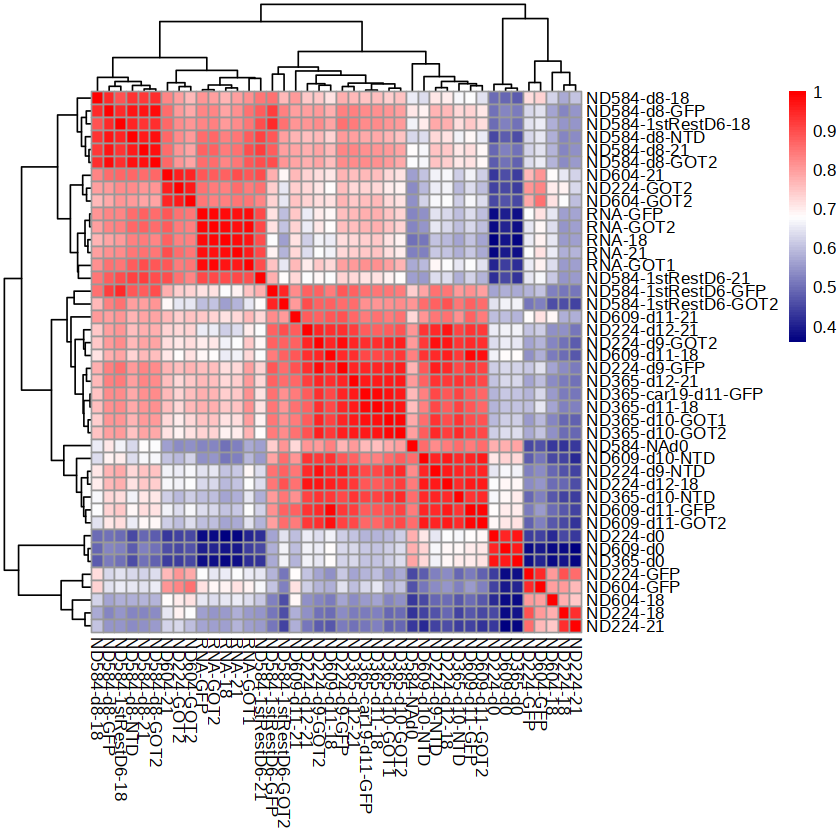

In [12]:
# heatmap samples

# get normalized counts correlation
normalized_counts_cor <- cor(normalized_counts, method = "spearman")

# create heatmap
pheatmap(normalized_counts_cor, color = colorRampPalette(c("navy", "white", "red"))(100))


## DESeq

In [13]:
# deseq (no adjustors)

# use get_de_genes() to get de genes (deseq object created above)
res_no_adj <- get_de_genes(dds_no_adj$dds, "Condition", "Activated", "Non Activated")

# sort results
res_no_adj_ordered <- res_no_adj$res[order(res_no_adj$res$padj),]

# view first 20 rows of the results
View(head(as.data.frame(res_no_adj_ordered), 20))

# save results to csv file
write.csv(as.data.frame(res_no_adj_ordered), file = "results_ordered_no_adj.csv")


using pre-existing size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

final dispersion estimates

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

fitting model and testing

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe charact

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
RP11-219A15.1,546.98707,6.853043,0.2709030,25.29703,3.443556e-141,5.262442e-137
HLA-B,5941.13872,-6.390874,0.3117490,-20.50006,2.150245e-93,1.643002e-89
HLA-F,225.20648,-5.063358,0.2695548,-18.78415,1.018064e-78,5.186019e-75
MDGA1,289.94439,6.126785,0.3312275,18.49721,2.174364e-76,8.307158e-73
CCDC144A,252.51455,6.795712,0.3689395,18.41958,9.150546e-76,2.796773e-72
KLRC1,625.30831,-3.852657,0.2317576,-16.62365,4.698353e-62,1.196670e-58
UTS2,150.71327,-6.210224,0.3974440,-15.62541,4.887833e-55,1.067084e-51
SCD5,87.73654,-3.788086,0.2799069,-13.53338,9.935042e-42,1.897841e-38
PIK3AP1,709.76290,-2.842391,0.2116564,-13.42927,4.074225e-41,6.918034e-38


## PCA

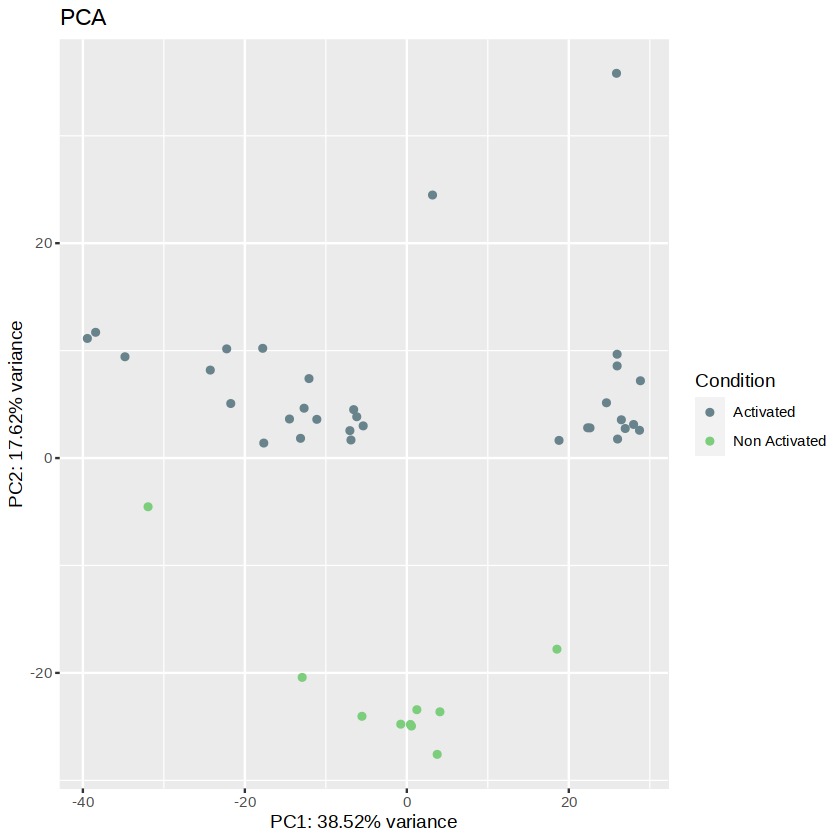

In [14]:
# pca plot (no adjustors)

# transform data to use in plot
vsd <- varianceStabilizingTransformation(dds_no_adj$dds, blind = FALSE)

# create PCA plot
pcaData <- plotPCA(vsd, intgroup = c("Condition"), returnData = TRUE)

# get the percent variance from PCA plot
percentVar <- round(100 * attr(pcaData, "percentVar"), digits = 2)

# format plot
ggplot(pcaData, aes(x = PC1, y = PC2, color = Condition)) + 
    geom_point() +
    labs(x = paste0("PC1: ", percentVar[1], "% variance"),
         y = paste0("PC2: ", percentVar[2], "% variance"),
         color = "Condition") +
    scale_color_manual(values = c("lightblue4", "palegreen3")) +
    ggtitle("PCA")


## Heatmap genes

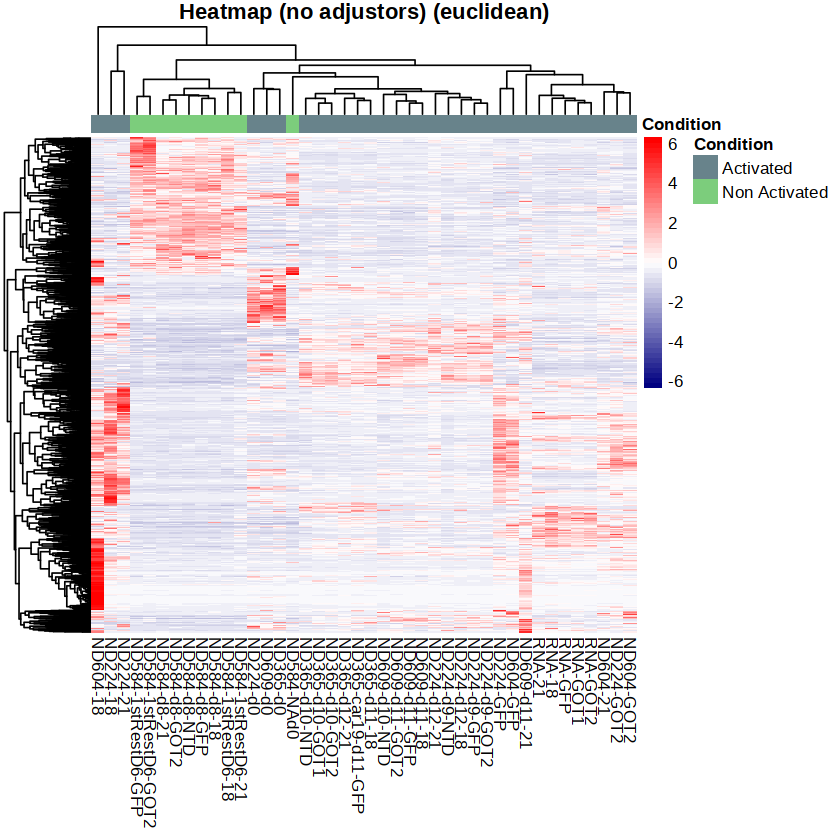

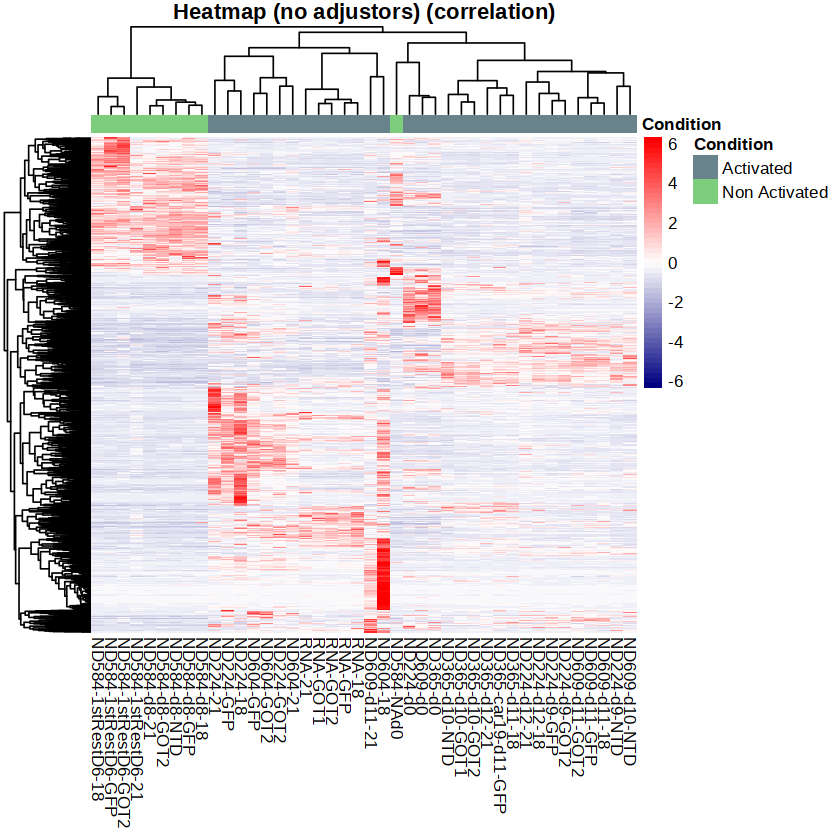

In [15]:
# heatmap genes (no adjustors)

# get subset of results where padj < 0.05
res_hm_no_adj <- subset(res_no_adj_ordered, padj < 0.05)

# sort results into descending LFC
res_hm_no_adj <- res_hm_no_adj[abs(res_hm_no_adj$log2FoldChange) > 1, ]

# convert results to a dataframe
res_hm_no_adj_df <- as.data.frame(res_hm_no_adj)

# get counts that correspond to significant genes
mat_hm_no_adj <- counts(dds_no_adj$dds, normalized = TRUE)[rownames(res_hm_no_adj_df), ]

# create dataframe for annotations
samples_list_no_adj <- colnames(mat_hm_no_adj)
samples_list_no_adj_df <- metadata[metadata$Sample_Name %in% samples_list_no_adj,]
samples_list_no_adj_df_tmp <- data.frame(samples_list_no_adj_df[, c("Condition")])
rownames(samples_list_no_adj_df_tmp) <- samples_list_no_adj_df$Sample_Name
samples_list_no_adj_df <- samples_list_no_adj_df_tmp
colnames(samples_list_no_adj_df) <- c("Condition")

# create list of annotation colors
ann_colors_no_adj <- list(Condition = c(Activated = "lightblue4", "Non Activated" = "palegreen3"))

# heatmap using euclidean
pheatmap(mat_hm_no_adj, scale = "row", color = colorRampPalette(c("navy", "white", "red"))(50), 
         annotation_col = samples_list_no_adj_df, annotation_colors = ann_colors_no_adj, 
         clustering_distance_cols = "euclidean", show_rownames = FALSE, main = "Heatmap (no adjustors) (euclidean)")

# heatmap using correlation
pheatmap(mat_hm_no_adj, scale = "row", color = colorRampPalette(c("navy", "white", "red"))(50), 
         annotation_col = samples_list_no_adj_df, annotation_colors = ann_colors_no_adj, 
         clustering_distance_cols = "correlation", show_rownames = FALSE, main = "Heatmap (no adjustors) (correlation)")


## Volcano plots

Warning message:
“ggrepel: 393 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


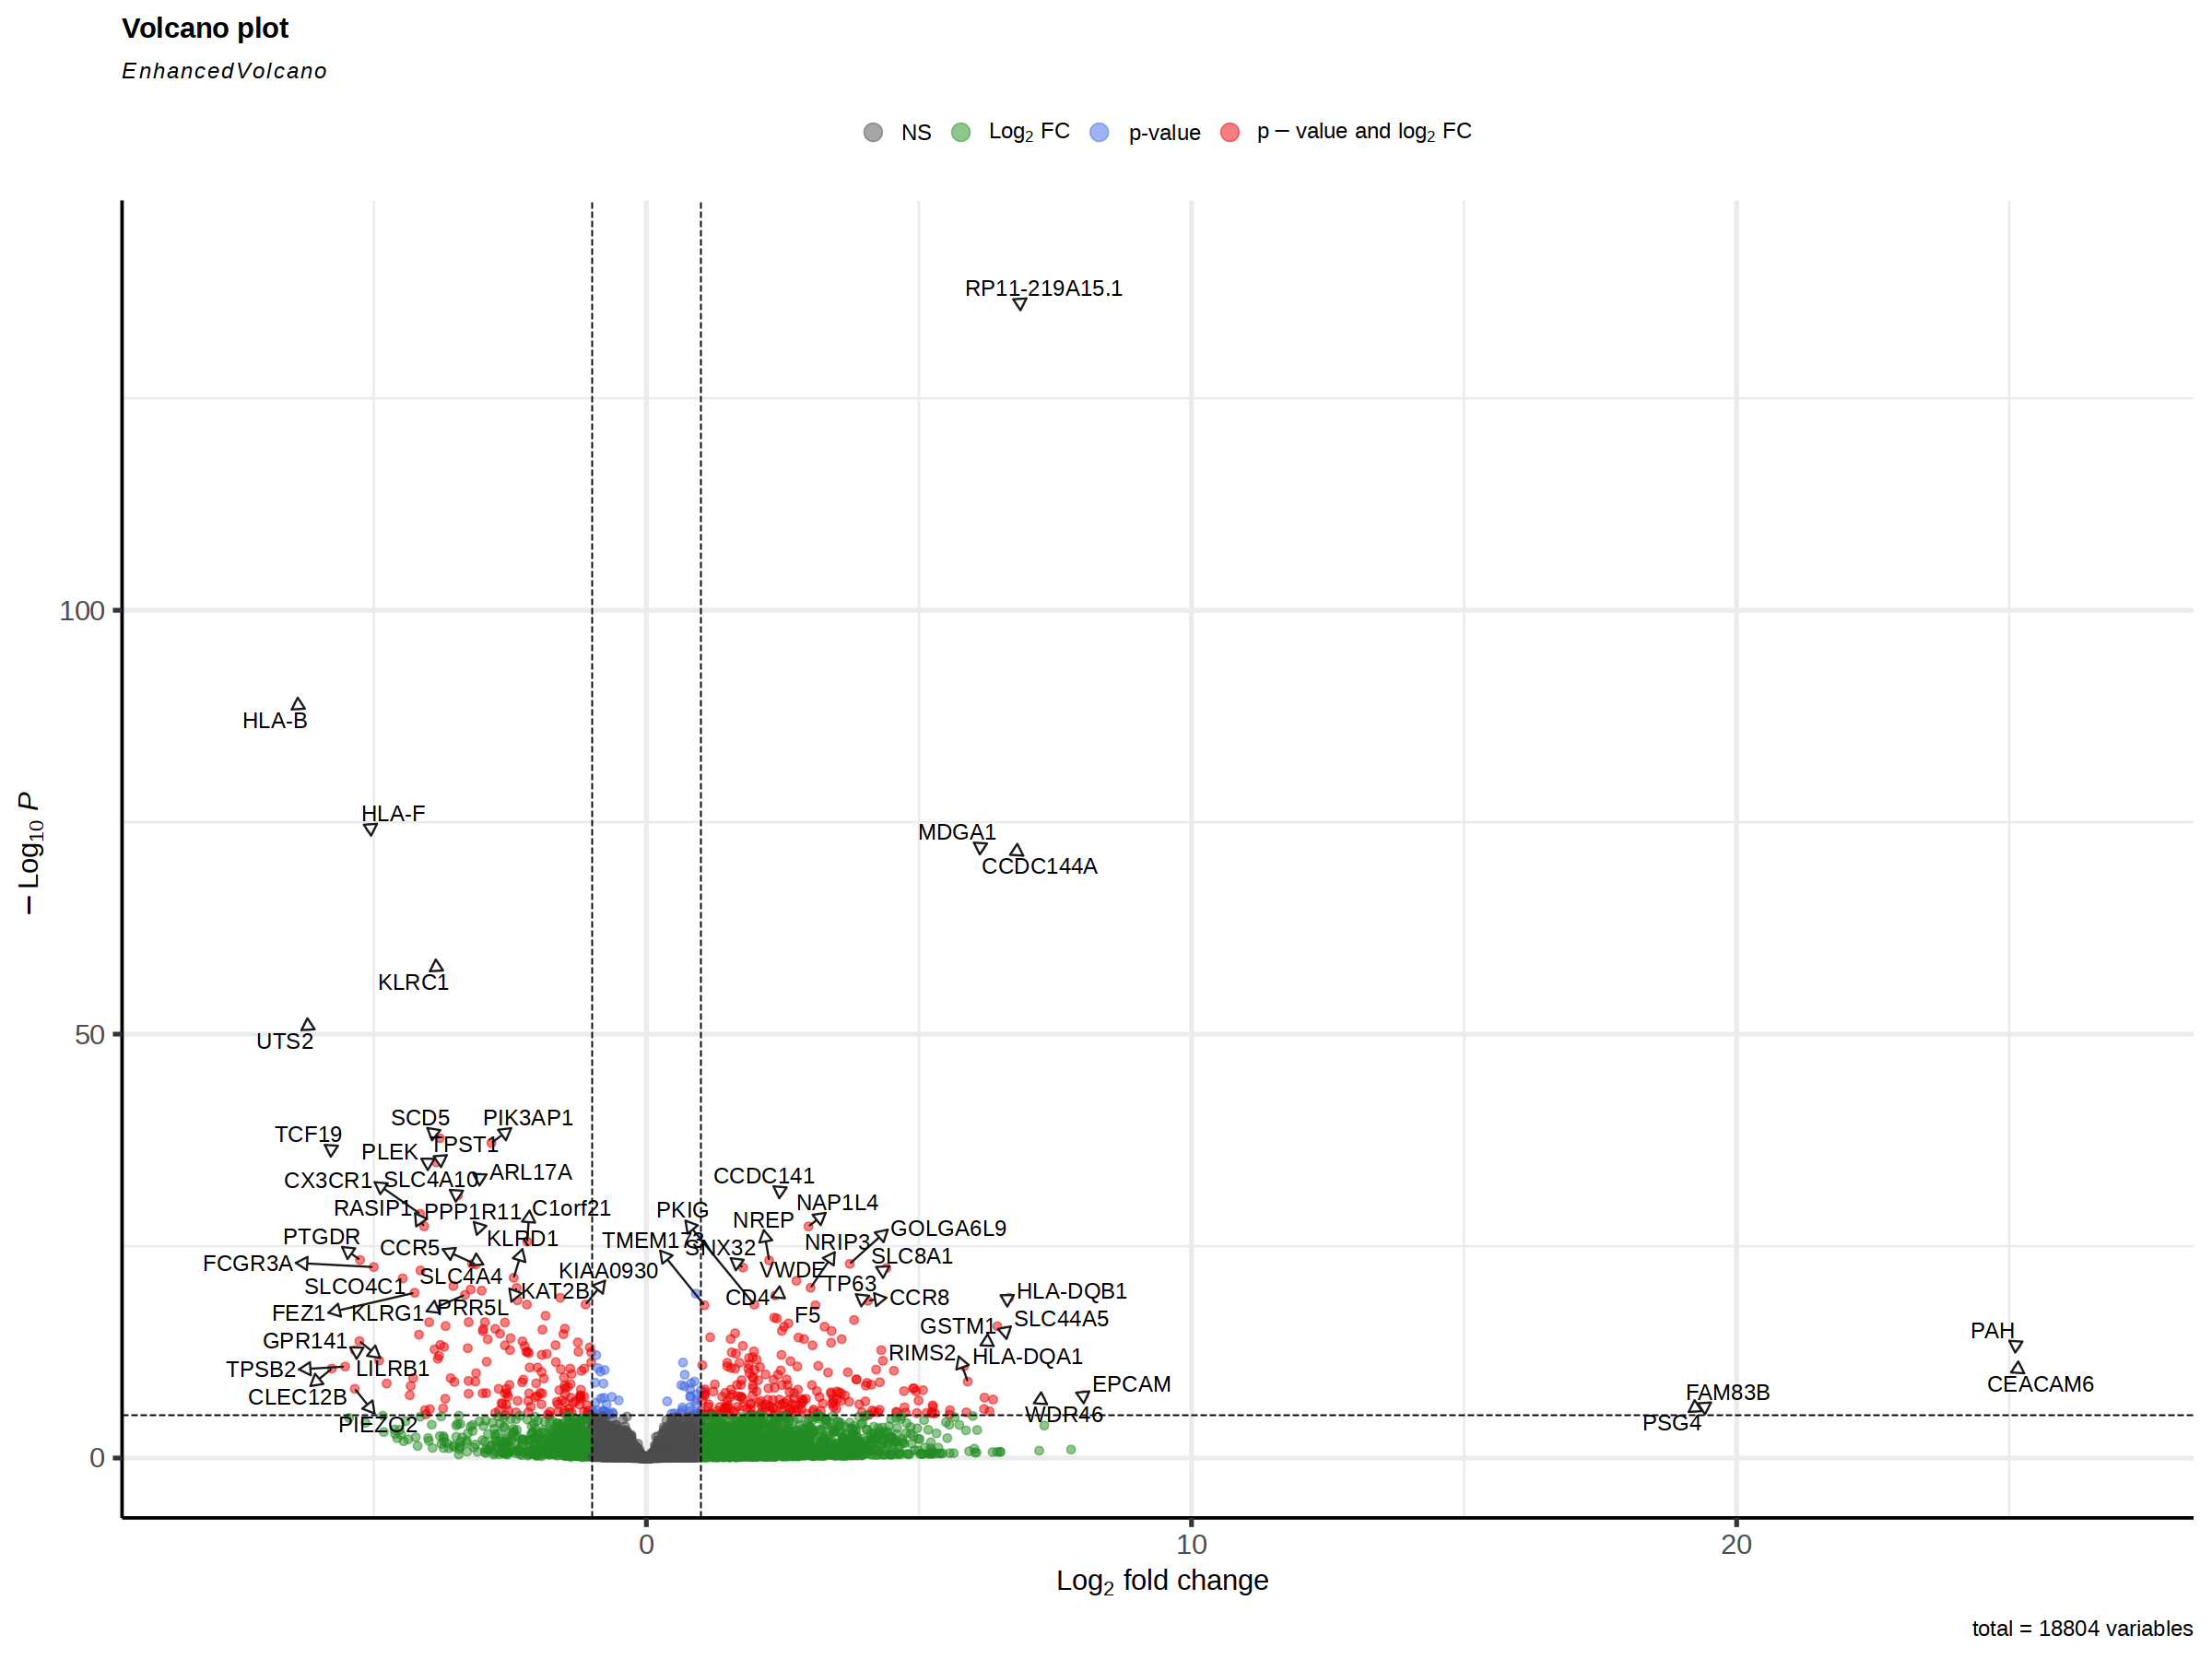

In [16]:
# enlarge the frame of the plot
options(repr.plot.width = 20, repr.plot.height = 15)

# volcano plot with no adjustors
EnhancedVolcano(res_no_adj$res, lab = rownames(res_no_adj$res), x = "log2FoldChange", y = "padj", drawConnectors = TRUE, title = "Volcano plot")
